### In this notebook, we will use PyTorch + Lightning to create and optimize a Decoder-Only Transformer, like the one shown in the picture below. Decoder-Only Transformers are taking over AI right now, and quite possibly their most famous use is in ChatGPT.

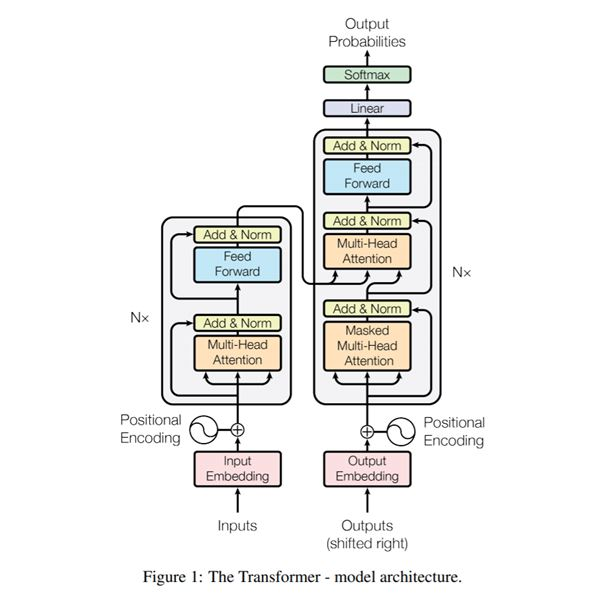

### Import Necessary Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F #used to access softmax() function to calculate attention
from torch.optim import Adam #used to fit neural network to the data for back propagation
from torch.utils.data import TensorDataset, DataLoader #imported these modules to creat large scale transformers

In [2]:
%pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.6/962.6 kB 30.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink

In [3]:
import pytorch_lightning as L #used for automatic code optimization and scaling in the cloud

### Create the input and output and data

#### In this tutorial we will build a simple Decoder-Only Transformer that can answer two super simple questions, What is computer science? and computer science is what?, and give them both the same answer, Awesome!!!

#### In order to keep track of our simple dataset, we'll create a dictionary that maps the words and tokens to ID numbers. This is because the class we will use to do word embedding for us, nn.Embedding(), only accepts ID numbers as input, rather than words or tokens.

In [4]:
token_to_id= {'what':0,
              'is':1,
              'computer science':2,
              'awesome':3,
              '<EOS>':4
              }

In [5]:
id_to_token = dict(map(reversed, token_to_id.items()))

In [6]:
inputs= torch.tensor([[token_to_id["what"],
                       token_to_id["is"],
                       token_to_id["computer science"],
                       token_to_id["<EOS>"],
                       token_to_id["awesome"]],
                      [token_to_id["computer science"],
                       token_to_id["is"],
                       token_to_id["what"],
                       token_to_id["<EOS>"],
                       token_to_id["awesome"]]])

In [7]:
labels = torch.tensor([[token_to_id["is"],
                        token_to_id["computer science"],
                        token_to_id["<EOS>"],
                        token_to_id["awesome"],
                        token_to_id["<EOS>"]],

                       [token_to_id["is"],
                        token_to_id["what"],
                        token_to_id["<EOS>"],
                        token_to_id["awesome"],
                        token_to_id["<EOS>"]]])

#### Then we will use the dictionary to create a Dataloader that contains the questions and the desired answers encoded as ID numbers. Ultimately we'll use the Dataloader to train the transformer. NOTE: Dataloaders are designed to scale to very large datasets, so this simple example should be useful even when you have a terabyte of text.

In [8]:
dataset= TensorDataset(inputs,labels)
dataloader= DataLoader(dataset)

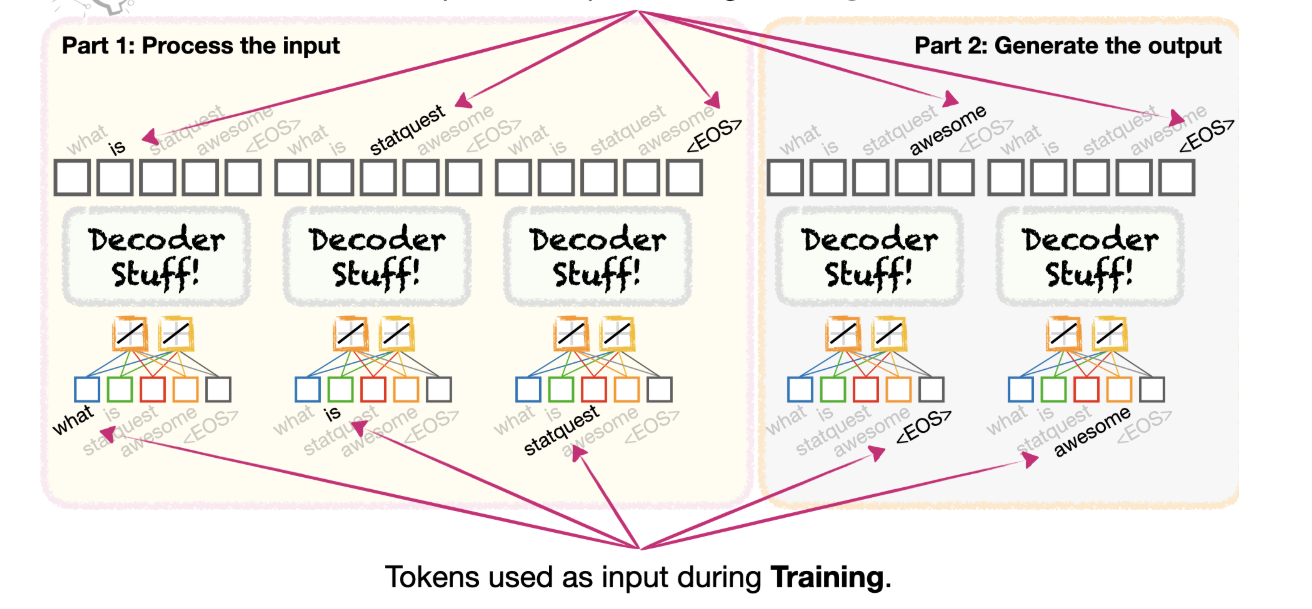

## Position Encoding

Position Encoding helps the transformer keep track of the order of the words in the input and the output.

There are a bunch of ways for a transformer to keep track of word order, but one popular method is to use a series of alternating sine and cosine curves (seen below).

 The number of sine and cosine curves depends on how many numbers, or word embedding values, we use to represent each token. In the context of Transformers, the number of numbers, or word embedding values, we use to represent each token is the dimension of the transformer.

 So, if the transformer's dimension is 2, meaning that it uses 2 numbers to represent each token, then we only need one sine and one cosine to generate two position encoding values.

 Increasing the period for each additional pair of curves ensures that each position is represented by a unique combination of values.

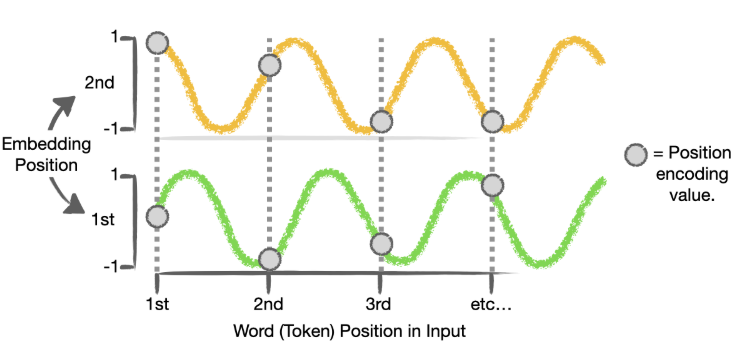

d_model is short for dimensions of the model which represents the number of word embedding values per token.

max_len = maximum number of tokens we allow as input.

Since we are precomputing the position encoding values and storing them in a lookup tablewe can use d_model and max_len to determine the number of rows and columns in that lookup table.

In [15]:
import torch
import torch.nn as nn

class PositionEncoding(nn.Module):
  def __init__(self, d_model=2, max_len=6):
    super().__init__()
    ## We call the super's init because by creating our own __init__() method, we overwrite the one
    #we inherited from nn.Module. So we have to explicity call nn.Module's __init__(), otherwise it
    #won't get initialized.

    #Now we create a lookup table, pe, of position encoding values and initialize all of them to 0.
    #To do this, we will make a matrix of 0s that has max_len rows and d_model columns.
    pe=torch.zeros(max_len, d_model)

    #Now we create a sequence of numbers for each position that a token can have in the input (or output).
    ## For example, if the input tokens where "I'm happy today!", then "I'm" would get the first
    ## position, 0, "happy" would get the second position, 1, and "today!" would get the third position, 2.
    ## NOTE: Since we are going to be doing math with these position indices to create the
    ## positional encoding for each one, we need them to be floats rather than ints. We use torch.arange to create floats

    ### Lastly, .unsqueeze(1) converts the single list of numbers that torch.arange creates into a matrix with
    ## one row for each index, and all of the indices in a single column. So if "max_len" = 3, then we
    ## would create a matrix with 3 rows and 1 column like this
    position= torch.arange(start=0, end=max_len,step=1).float().unsqueeze(1)

    ### The positional encoding equations used in "Attention is all you need" are.
    ## PE(pos, 2i)   = sin(pos / 10000^(2i/d_model))
    ## PE(pos, 2i+1) = cos(pos / 10000^(2i/d_model))
    ## and we see, within the sin() and cos() functions, we divide "pos" by some number that depends
    ## on the index (i) and total number of PE values we want per token (d_model).
    ## NOTE: When the index, i, is 0 then we are calculating the y-axis coordinates on the **first pair**
    ## of sine and cosine curves. When i=1, then we are calculating the y-axis coordiantes on the
    ## **second pair** of sine and cosine curves. etc. etc.

    embedding_index=torch.arange(start=0, end=d_model, step=2).float()

    #Now let's create an index for the embedding positions to simplify the code a little more.
    # Div term is originally calculated with the following formula:div_term = torch.exp(torch.arange(start=0, end=d_model, step=2).float() * -(math.log(10000.0) / d_model))
    #However to problem with this is underflowing (getting close to 0), so to prevent this i wrapped everything in a call to torch.exp() and used torch.log to convert it to a tensor
    div_term= 1/torch.tensor(10000.0)**(embedding_index/d_model)
    pe[:,0::2]=torch.sin(position*div_term)
    pe[:,1::2]=torch.cos(position*div_term)


    #Now we "register 'pe'.
    self.register_buffer('pe',pe)
    ## "register_buffer()" ensures that
    ## 'pe' will be moved to wherever the model gets
    ## moved to. So if the model is moved to a GPU, then,
    ## even though we don't need to optimize 'pe', it will
    ## also be moved to that GPU. This, in turn, means
    ## that accessing 'pe' will be relatively fast copared
    ## to having a GPU have to get the data from a CPU.


# we will add the position encoding values to the word embedding values
  def forward(self, word_embeddings):
    return word_embeddings+ self.pe[:word_embeddings.size(0),:]

#### We're going to code an Attention class to do all of the types of attention that a transformer might need: Self-Attention, Masked Self-Attention (which is used by the Decoder during training), and Encoder-Decoder Attention.

Self-Attention is a type of attention used in Encoder-Decoder and Encoder-Only transformers. It allows every word in a phrase to define a relationship with any other word in the phrase, regardless of the order of the words. In other words, if the phrase is The pizza came out of the oven and it tasted good!, then the word it can define it's relationship with every word in that phrase, including words that came after it, like tasted and good,

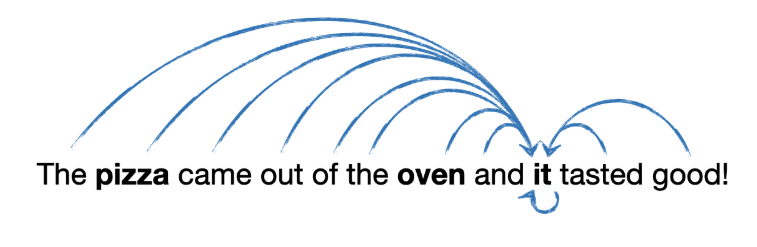

Masked Self-Attention is used by Encoder-Decoder and Decoder-Only transformers and it allows each word in a phrase to define a relationship with itself and the words that came before it. In other words, Masked Self-Attention prevents the transformer from "looking ahead".

 This is illustrated below where the word it can define relationships with itself and everything that came earlier in the input. In Encoder-Decoder transformers, Masked Self-Attention is used during training, when we know what the output should be, but we still force the decoder to generate it one token at a time, thus, limiting attention to only output words that came earlier.

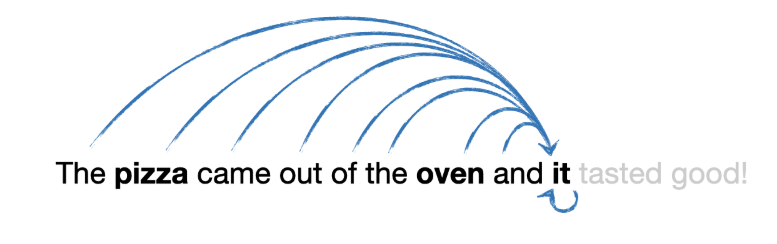

Now that we have a general sense of the three types of attention used in transformers, we can talk about how it's calculated.

First, the general equations for the different types of attention are almost identical as seen in the figure below. In the equations, Q is for the Query matrix, K is for the Key matrix and V is for the Value matrix. On the left, we have the equation for Self-Attention and Encoder-Decoder Attention.

The differences in these types of attention are not from the equation we use, but from how the Q, K, and V matrices are computed. On the right, we see the equation for Masked Self-Attention and the only difference it has from the equation on the left is the addition of a Mask matrix, M, that prevents words that come after a specific Query from being included in the final attention scores.

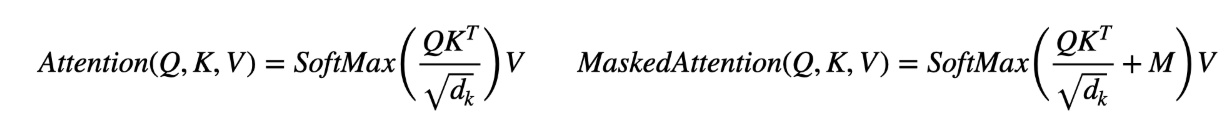

First, given word embedding values for each word/token in the input phrase SOS let's go in matrix form, we multiply them by matrices of weights to create Queries, Keys, and Values

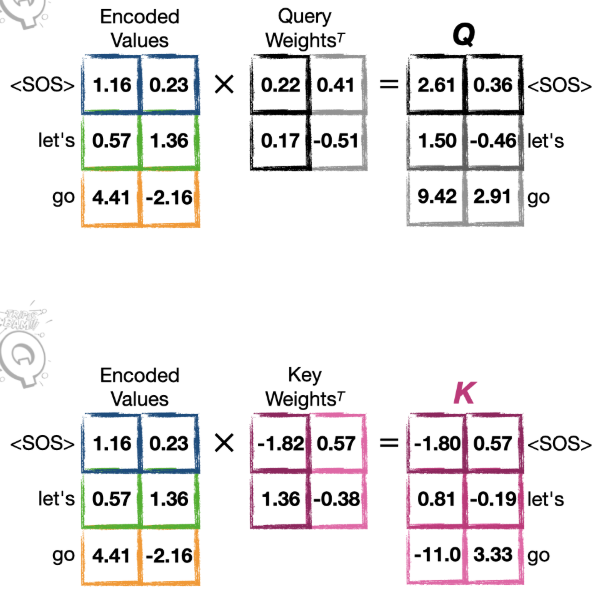

We then multiply the Queries by the transpose of the Keys so that the query for each word calculates a similarity value with the keys for all of the words. NOTE: As seen in the illustration below, Masked Self-Attention calculates the values for all Query/Key pairs, but, ultimately, ignores values for when a token's Query comes before other token's Keys. For example, if the Query is for the first token SOS, then Masked Self-Attention will ignore the values calculated with Keys for Let's and go because those tokens come after SOS

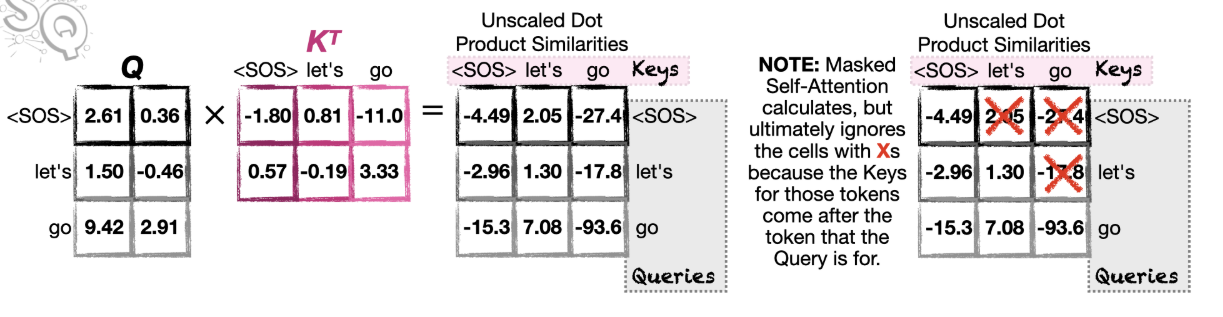

The next step is to scale the similarity scores by the square root of the number of columns in the Key matrix, which represents the number of values used to represent each token. In this case, we scale by the square root of 2

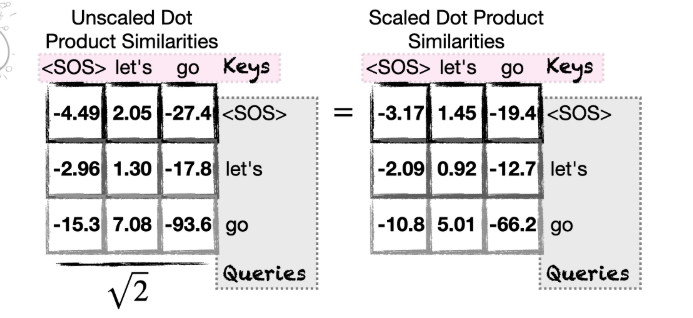

Now, if we were doing Masked Self-Attention, we would mask out the values we want to ignore by adding -infinity to them, as seen below. This step is the only difference between Self-Attention and Masked Self-Attention.

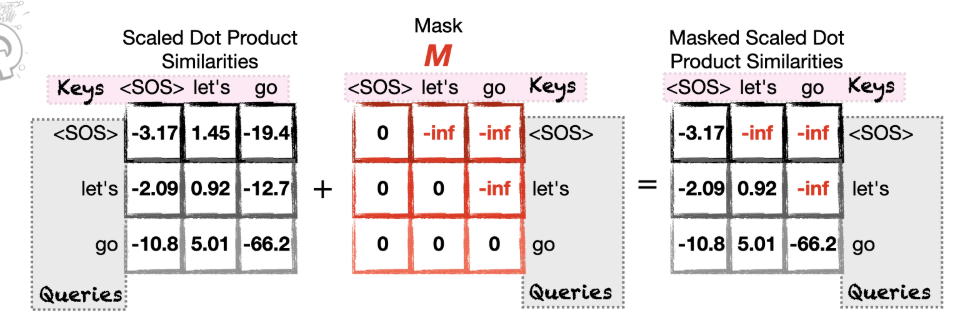

The next step is to apply the SoftMax() function to each row in the scaled similarities. We'll do this first for the Self-Attention without a mask (below).

The SoftMax() function gives us percentages that the Values for each token should contribute to the attention score for a specific token. Thus, we can get the final attention scores by multiplying the percentages with the Values in matrix V. First, we'll do this with the unmasked percentages

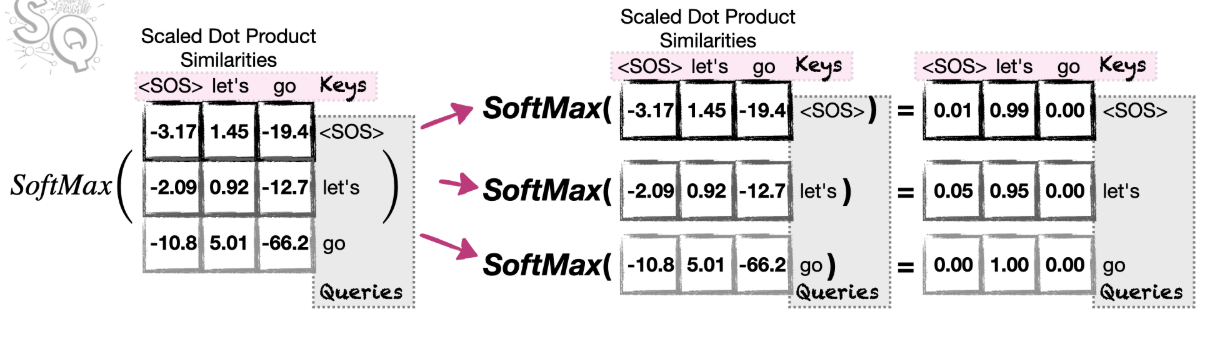

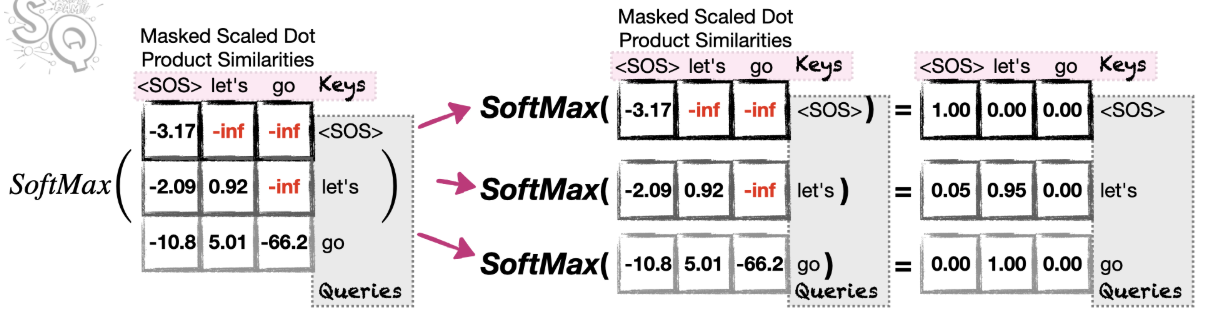

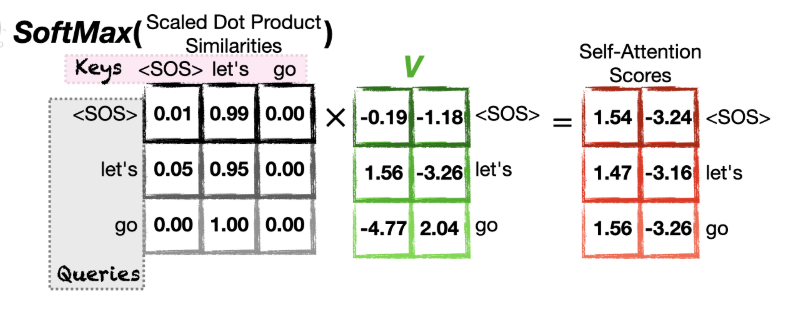

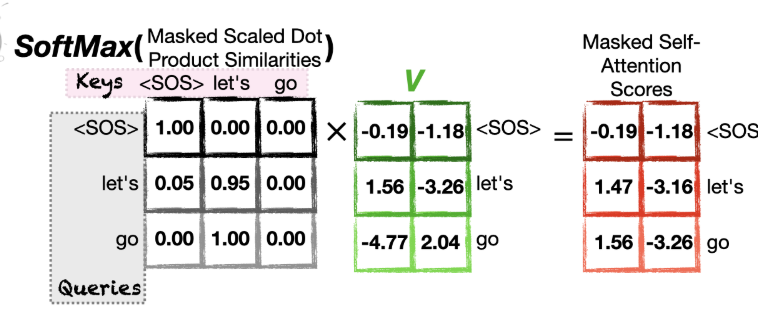

### Attention Class

In [10]:
class Attention(nn.Module):
  def __init__(self,d_model=2):
    super().__init__()
    self.d_model= d_model

    ## Initialize the Weights (W) that we'll use to create the
        ## query (q), key (k) and value (v) numbers for each token
    self.query= nn.Linear(in_features=d_model, out_features=d_model, bias=False) #query matrix
    self.key= nn.Linear(in_features=d_model, out_features=d_model, bias=False) #key matrix
    self.value= nn.Linear(in_features=d_model, out_features=d_model, bias= False) # value matrix

    ## NOTE: In this simple example, we are not training on the data in "batches"
        ## However, by defining variables for row_dim and col_dim, we could
        ## allow for batches by setting row_dim to 1 and col_com to 2.
    self.row_dim=0
    self.col_dim=1

  def forward (self, encodings_for_q, encodings_for_k, encodings_for_v, mask=None):
    ## Create the query, key and values using the encodings
        ## associated with each token (token encodings)
       ## NOTE: For Encoder-Decoder Attention, the encodings for q come from
        ##the decoder and the encodings for k and v come from the output
        ## from the encoder.
    q=self.query(encodings_for_q)
    k=self.key(encodings_for_k)
    v=self.value(encodings_for_v)

    ## Compute attention scores
        ## the equation is (q * k^T)/sqrt(d_model)
        ## NOTE: It seems most people use "reverse indexing" for the dimensions when transposing k
        ## k.transpose(dim0, dim1) will transpose k by swapping dim0 and dim1
        ## In standard matrix notation, we would want to swap rows (dim=0) with columns (dim=1)
        ## If we have 3 dimensions, because of batching, and the batch was the first dimension
        ## And thus dims are defined batch = 0, rows = 1, columns = 2
        ## then dim0=-2 = 3 - 2 = 1. dim1=-1 = 3 - 1 = 2.

    sims= torch.matmul(q, k.transpose(dim0=self.row_dim, dim1=self.col_dim))
    scaled_sims= sims/torch.tensor(k.size(self.col_dim)**0.5)

    if mask is not None:
      ## Here we are masking out things we don't want to pay attention to,
        ## like tokens that come after the current token.
      scaled_sims= scaled_sims.masked_fill(mask==0,value=-1e9)

    ## Apply softmax to determine what percent of each token's value to
        ## use in the final attention values.
    attention_percents= F.softmax(scaled_sims, dim=self.col_dim)

    # Scale the values by their associated percentages and add them up
    attention_scores=torch.matmul(attention_percents, v)
    return attention_scores

### Decoder Class

A Decoder-Only Transformer simply brings together...

Word Embedding

Position Encoding

Masked Self-Attention

Residual Connections

A fully connected layer

SoftMax - However, the loss function we are using nn.CrossEntropyLoss(), applies the SoftMax for us.

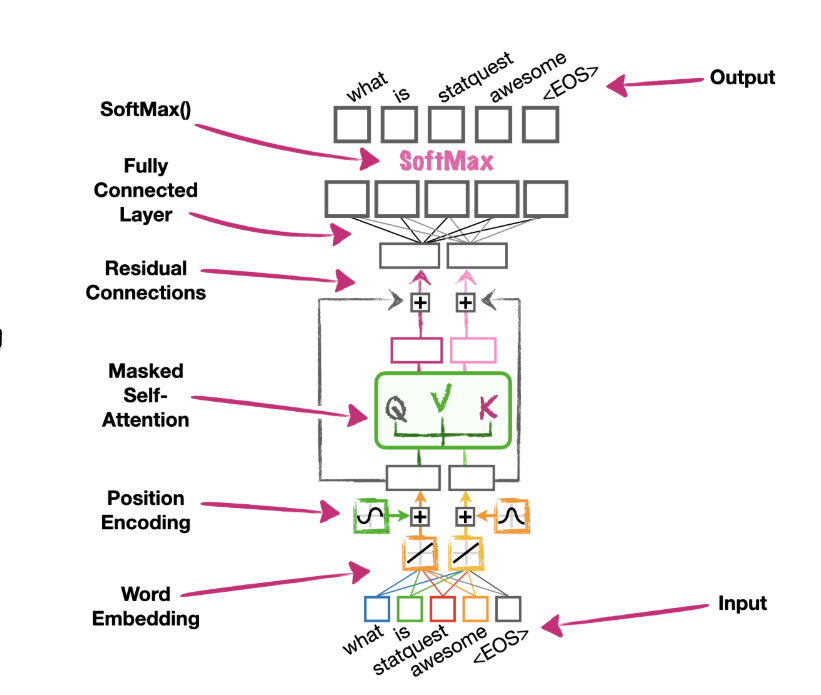

In [11]:
class DecoderOnlyTransformer(L.LightningModule):

    def __init__(self, num_tokens=4, d_model=2, max_len=6):
        super().__init__()
        L.seed_everything(seed=42)
        self.we = nn.Embedding(num_embeddings=num_tokens,
                               embedding_dim=d_model)
        self.pe = PositionEncoding(d_model=d_model,
                                   max_len=max_len)
        self.self_attention = Attention(d_model=d_model)
        ## NOTE: In this simple example, we are not doing multi-head attention
        ## If we wanted to do multi-head attention, we could
        ## initailize more Attention objects like this...
        ## self.self_attention_2 = Attention(d_model=d_model)
        ## self.self_attention_3 = Attention(d_model=d_model)
        ## If d_model=2, then using 3 self_attention objects would
        ## result in d_model*3 = 6 self-attention values per token,
        ## so we would need to initialize
        ## a fully connected layer to reduce the dimension of the
        ## self attention values back down to d_model like this:
        ## self.reduce_attention_dim = nn.Linear(in_features=(num_attention_heads*d_model), out_features=d_model)

        self.fc_layer = nn.Linear(in_features=d_model, out_features=num_tokens)
        self.loss = nn.CrossEntropyLoss()


    def forward(self, token_ids):
      ### For the decoder-only transformer, we need to use "masked self-attention" so that
        ## when we are training we can't cheat and look ahead at
        ## what words come after the current word.
        ## To create the mask we are creating a matrix where the lower triangle
        ## is filled with 0, and everything above the diagonal is filled with 0s.

        word_embeddings = self.we(token_ids)
        position_encoded = self.pe(word_embeddings)
        mask = torch.tril(torch.ones((token_ids.size(dim=0), token_ids.size(dim=0)), device=self.device))
        mask = mask == 0
        self_attention_values = self.self_attention(position_encoded,
                                                    position_encoded,
                                                    position_encoded,
                                                    mask=mask)
        residual_connection_values = position_encoded + self_attention_values
        fc_layer_output = self.fc_layer(residual_connection_values)
        return fc_layer_output


    def configure_optimizers(self):
        ## configure_optimizers() simply passes the parameters we want to
        ## optimize to the optimzes and sets the learning rate
        return Adam(self.parameters(), lr=0.1)


    def training_step(self, batch, batch_idx):
        ## training_step() is called by Lightning trainer when
        ## we want to train the model.
        input_tokens, labels = batch # collect input
        output = self.forward(input_tokens[0])
        loss = self.loss(output, labels[0])

        return loss

To use the transformer, we run an input phrase, either what is computer science <**EOS**> or computer science is what **<EOS>**, through the transformer to get the next predicted token. If the next predicted token is not <**EOS**>, then we add the predicted token to the input tokens and run that through the transformer and repeat until we get the **<EOS>** token or reach the maximum sequence length.

In [12]:
## First, create a model from DecoderOnlyTransformer()
model= DecoderOnlyTransformer(num_tokens=len(token_to_id),d_model=2, max_len=6)

## Now create the input for the transformer.
model_input= torch.tensor([token_to_id["what"],
                            token_to_id["is"],
                            token_to_id["computer science"],
                            token_to_id["<EOS>"]])
input_length= model_input.size(dim=0)

## Now get get predictions from the model
## NOTE: "predictions" is the output from the fully connected layer,
##not a softmax() function. We could, if we wanted to,
##Run "predictions" through a softmax() function, but
## since we're going to select the item with the largest value
## we can just use argmax instead.
predictions=model(model_input)

## We'll store predicted_id in an array, predicted_ids, that
## we'll add to each time we predict a new output token.
predicted_id= torch.tensor([torch.argmax(predictions[-1,:])])
predicted_ids= predicted_id

max_length=6
## Now use a loop to predict output tokens until we get an
## <EOS> token.
for i in range(input_length, max_length):
  if (predicted_id==token_to_id["<EOS>"]): # if the prediction is <EOS>, then we are done
    break
  model_input= torch.cat((model_input, predicted_id))
  predictions=model(model_input)
  predicted_id= torch.tensor([torch.argmax(predictions[-1,:])])
  predicted_ids= torch.cat((predicted_ids, predicted_id))

## Now printout the predicted output phrase.
print("Predicted Tokens:\n")
for id in predicted_ids:
    print("\t", id_to_token[id.item()])

INFO:lightning_fabric.utilities.seed:Seed set to 42


Predicted Tokens:

	 <EOS>


### And, without training, the transformer predicts EOS, but we wanted it to predict awesome EOS So, since the transformer didn't correctly respond to the prompt, we'll have to train it


In [13]:
trainer= L.Trainer(max_epochs=100)
trainer.fit(model, dataloader)

INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type             | Params | Mode 
------------------------------------------------------------
0 | we             | Embedding        | 10     | train
1 | pe             | PositionEncoding | 0      | train
2 | self_attention | Attention        | 12     | train
3 | fc_layer       | Linear           | 15     | train
4 | loss           | CrossEntropyLoss | 0      | train
------------------------------------------------------------
37        Tr

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Now that we've trained the transformer, let's use it!

To use the transformer that we just trained, we just repeat what we did earlier, only this time we use the trained transformer instead of an untrained transformer. First, we'll see if it correctly responds to the prompt Computer science is what?

In [14]:
## Now let's ask the other question...
model_input = torch.tensor([token_to_id["computer science"],
                            token_to_id["is"],
                            token_to_id["what"],
                            token_to_id["<EOS>"]])
input_length = model_input.size(dim=0)

predictions = model(model_input)
predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
predicted_ids = predicted_id

for i in range(input_length, max_length):
    if (predicted_id == token_to_id["<EOS>"]): # if the prediction is <EOS>, then we are done
        break

    model_input = torch.cat((model_input, predicted_id))

    predictions = model(model_input)
    predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
    predicted_ids = torch.cat((predicted_ids, predicted_id))

print("Predicted Tokens:\n")
for id in predicted_ids:
    print("\t", id_to_token[id.item()])

Predicted Tokens:

	 <EOS>


We got the correct output! Now let's see if it correctly responds to the prompt what is computer science?

In [ ]:
model_input = torch.tensor([token_to_id["what"],
                            token_to_id["is"],
                            token_to_id["computer science"],
                            token_to_id["<EOS>"]])
input_length = model_input.size(dim=0)

predictions = model(model_input)
predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
predicted_ids = predicted_id

for i in range(input_length, max_length):
    if (predicted_id == token_to_id["<EOS>"]): # if the prediction is <EOS>, then we are done
        break

    model_input = torch.cat((model_input, predicted_id))

    predictions = model(model_input)
    predicted_id = torch.tensor([torch.argmax(predictions[-1,:])])
    predicted_ids = torch.cat((predicted_ids, predicted_id))

print("Predicted Tokens:\n")
for id in predicted_ids:
    print("\t", id_to_token[id.item()])

Predicted Tokens:

	 <EOS>


And the output for both questions is awesome EOS, which is exactly what we want.